# Imports and Initializations

In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [64]:
data = pd.read_csv('../data/crsp_SPY_daily.csv')
data.rename(columns={'date': 'DATE'}, inplace=True)
print(data.head())
print(data.columns)

/var/folders/4j/c26320x118b30p_z9wtdxtg40000gn/T/ipykernel_392/3087263516.py:1: DtypeWarning: Columns (5,6,9,19,22,24,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/crsp_SPY_daily.csv')


   PERMNO        DATE NAMEENDT  SHRCD  EXCHCD SICCD    NCUSIP TICKER  \
0   10104  2014-01-02      NaN   11.0     1.0  7372  68389X10   ORCL   
1   10104  2014-01-03      NaN   11.0     1.0  7372  68389X10   ORCL   
2   10104  2014-01-06      NaN   11.0     1.0  7372  68389X10   ORCL   
3   10104  2014-01-07      NaN   11.0     1.0  7372  68389X10   ORCL   
4   10104  2014-01-08      NaN   11.0     1.0  7372  68389X10   ORCL   

        COMNAM SHRCLS  ... CFACPR  CFACSHR OPENPRC NUMTRD      RETX    vwretd  \
0  ORACLE CORP    NaN  ...    1.0      1.0   37.78    NaN -0.010977 -0.008757   
1  ORACLE CORP    NaN  ...    1.0      1.0   37.65    NaN -0.005814  0.000491   
2  ORACLE CORP    NaN  ...    1.0      1.0   37.64    NaN -0.003987 -0.003340   
3  ORACLE CORP    NaN  ...    1.0      1.0   37.66    NaN  0.010141  0.006090   
4  ORACLE CORP    NaN  ...    1.0      1.0   37.79    NaN -0.003435  0.000155   

     vwretx    ewretd    ewretx    sprtrn  
0 -0.008884 -0.004051 -0.004084 -0.0

# Returns Data Analysis Functions

In [ ]:
def plot_ticker_returns(ticker, data):
    """
    Plot end-of-day returns for a ticker from CRSP data and YFinance.
    
    Parameters:
    ticker (str): The stock ticker symbol.
    data (pd.DataFrame): DataFrame containing 'TICKER', 'DATE', and 'RET' columns.
    """
    # Filter the data for only the specified ticker
    ticker_data = data[data['TICKER'] == ticker]

    # Get the date range from the filtered data
    start_date = ticker_data['DATE'].min()
    end_date = pd.to_datetime(ticker_data['DATE'].max()) + pd.Timedelta(days=1)

    # Fetch data from yfinance for the same date range
    ticker_yf = yf.download(ticker, start=start_date, end=end_date)

    # Ensure the date columns are in datetime format
    ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])
    ticker_yf.index = pd.to_datetime(ticker_yf.index)

    # Calculate YFinance returns
    ticker_yf['Returns'] = ticker_yf['Adj Close'].pct_change()

    # Merge the two datasets on the date
    merged_data = pd.merge(ticker_data, ticker_yf, left_on='DATE', right_index=True, suffixes=('_crsp', '_yf'))

    # Plot the end of day returns
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['DATE'], merged_data['RET'], label=f'CRSP {ticker} Returns')
    plt.plot(merged_data['DATE'], merged_data['Returns'], label=f'YFinance {ticker} Returns')
    plt.legend()
    plt.title(f'{ticker} End of Day Returns: CRSP vs YFinance')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.show()


[*********************100%%**********************]  1 of 1 completed

2014-01-02



/var/folders/4j/c26320x118b30p_z9wtdxtg40000gn/T/ipykernel_392/1958610776.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])


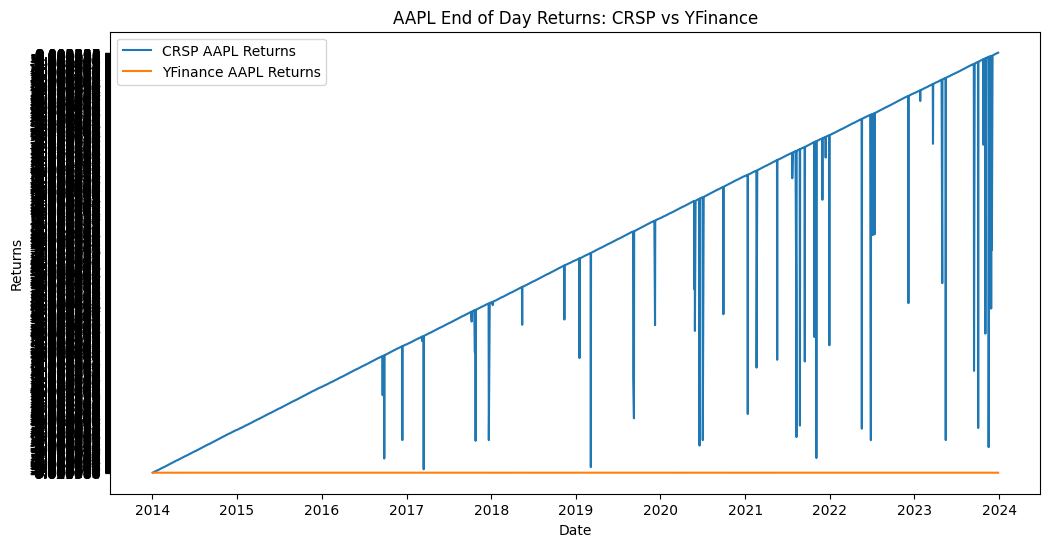

In [81]:
plot_ticker_returns('AAPL', data)

In [ ]:
def analyze_ticker(ticker, data):
    """
    Analyze the differences in returns between CRSP and YFinance data for a given ticker.

    Parameters:
    ticker (str): The stock ticker symbol.
    data (pd.DataFrame): DataFrame containing 'TICKER', 'DATE', and 'RET' columns.
    
    Returns:
    dict: A dictionary containing statistical analysis and other information.
    """
    # Filter the data for only the specified ticker
    ticker_data = data[data['TICKER'] == ticker]

    # Get the date range from the filtered data
    start_date = ticker_data['DATE'].min()
    end_date = pd.to_datetime(ticker_data['DATE'].max()) + pd.Timedelta(days=1)

    # Fetch data from yfinance for the same date range
    ticker_yf = yf.download(ticker, start=start_date, end=end_date)

    # Ensure the date columns are in datetime format
    ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])
    ticker_yf.index = pd.to_datetime(ticker_yf.index)

    # Merge the two datasets on the date
    merged_data = pd.merge(ticker_data, ticker_yf, left_on='DATE', right_index=True, suffixes=('_crsp', '_yf'))

    # Calculate the differences in returns
    merged_data['Return_Diff'] = merged_data['RET'].astype(float) - merged_data['Adj Close'].pct_change()

    # Calculate statistics
    avg_diff = merged_data['Return_Diff'].mean()
    max_diff = merged_data['Return_Diff'].max()
    min_diff = merged_data['Return_Diff'].min()

    # Filter the differences greater than 0.0001
    significant_diffs = merged_data[merged_data['Return_Diff'].abs() > 0.0001]

    # Count the number of significant differences
    num_significant_diffs = significant_diffs['Return_Diff'].notna().sum()

    # Calculate the ratio of significant differences to the number of entries
    ratio_significant_diffs = num_significant_diffs / len(merged_data)

    # Calculate statistics for significant differences
    avg_significant_diff = significant_diffs['Return_Diff'].mean()
    max_significant_diff = significant_diffs['Return_Diff'].max()
    min_significant_diff = significant_diffs['Return_Diff'].min()

    # Find dates present in ticker_yf but not in ticker_data
    dates_in_data_not_in_yf = ticker_data[~ticker_data['DATE'].isin(ticker_yf.index)]['DATE']

    # Find dates present in ticker_data but not in ticker_yf
    dates_in_yf_not_in_data = ticker_yf[~ticker_yf.index.isin(ticker_data['DATE'])].index

    # Plot the differences in returns
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['DATE'], merged_data['Return_Diff'], label=f'{ticker} Return Differences', color='black', linestyle='--')
    plt.axhline(0, color='red', linestyle=':', label='Zero Difference')
    plt.legend()
    plt.title(f'{ticker} Return Differences: CRSP vs YFinance')
    plt.xlabel('Date')
    plt.ylabel('Return Difference')
    plt.show()

    return {
        'avg_diff': avg_diff,
        'max_diff': max_diff,
        'min_diff': min_diff,
        'num_significant_diffs': num_significant_diffs,
        'ratio_significant_diffs': ratio_significant_diffs,
        'avg_significant_diff': avg_significant_diff,
        'max_significant_diff': max_significant_diff,
        'min_significant_diff': min_significant_diff,
        'dates_in_crsp_not_in_yf': dates_in_data_not_in_yf,
        'dates_in_yf_not_in_crsp': dates_in_yf_not_in_data
    }


[*********************100%%**********************]  1 of 1 completed
/var/folders/4j/c26320x118b30p_z9wtdxtg40000gn/T/ipykernel_392/1541663662.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])


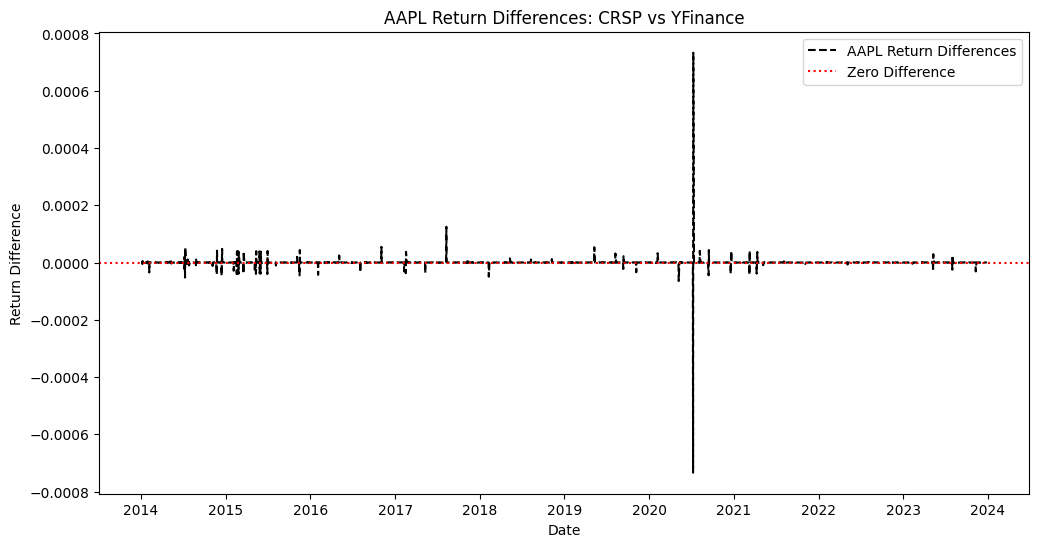

{'avg_diff': np.float64(-7.438625059010445e-09),
 'max_diff': np.float64(0.0007328482049259333),
 'min_diff': np.float64(-0.0007343234542917655),
 'num_significant_diffs': np.int64(3),
 'ratio_significant_diffs': np.float64(0.0011928429423459245),
 'avg_significant_diff': np.float64(4.110434485538354e-05),
 'max_significant_diff': np.float64(0.0007328482049259333),
 'min_significant_diff': np.float64(-0.0007343234542917655),
 'dates_in_crsp_not_in_yf': 213834   2023-12-29
 Name: DATE, dtype: datetime64[ns],
 'dates_in_yf_not_in_crsp': DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)}

In [89]:
analyze_ticker('AAPL', data)

# Adjusted End of Day Price Analysis

In [ ]:

def plot_ticker_prices(ticker, data):
    """
    Plot adjusted end-of-day prices for a ticker from CRSP data and YFinance.
    
    Parameters:
    ticker (str): The stock ticker symbol.
    data (pd.DataFrame): DataFrame containing 'TICKER', 'DATE', 'PRC', and 'CFACPR' columns.
    """
    # Filter the data for only the specified ticker
    ticker_data = data[data['TICKER'] == ticker]

    # Get the date range from the filtered data
    start_date = ticker_data['DATE'].min()
    end_date = pd.to_datetime(ticker_data['DATE'].max()) + pd.Timedelta(days=1)

    # Fetch data from yfinance for the same date range
    ticker_yf = yf.download(ticker, start=start_date, end=end_date)

    # Ensure the date columns are in datetime format
    ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])
    ticker_yf.index = pd.to_datetime(ticker_yf.index)

    # Calculate adjusted prices for CRSP data
    ticker_data['Adj_Price_crsp'] = ticker_data['PRC'] / ticker_data['CFACPR']

    # Extract the adjusted closing prices from YFinance
    ticker_yf['Adj_Price_yf'] = ticker_yf['Adj Close']

    # Merge the two datasets on the date
    merged_data = pd.merge(ticker_data[['DATE', 'Adj_Price_crsp']], 
                           ticker_yf[['Adj_Price_yf']], 
                           left_on='DATE', 
                           right_index=True)

    # Plot the adjusted prices
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['DATE'], merged_data['Adj_Price_crsp'], label=f'CRSP {ticker} Adjusted Price')
    plt.plot(merged_data['DATE'], merged_data['Adj_Price_yf'], label=f'YFinance {ticker} Adjusted Price')
    plt.legend()
    plt.title(f'{ticker} Adjusted End of Day Prices: CRSP vs YFinance')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price')
    plt.show()


[*********************100%%**********************]  1 of 1 completed
/var/folders/4j/c26320x118b30p_z9wtdxtg40000gn/T/ipykernel_392/1312015280.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])
/var/folders/4j/c26320x118b30p_z9wtdxtg40000gn/T/ipykernel_392/1312015280.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['Adj_Price_crsp'] = ticker_data['PRC'] / ticker_data['CFACPR']


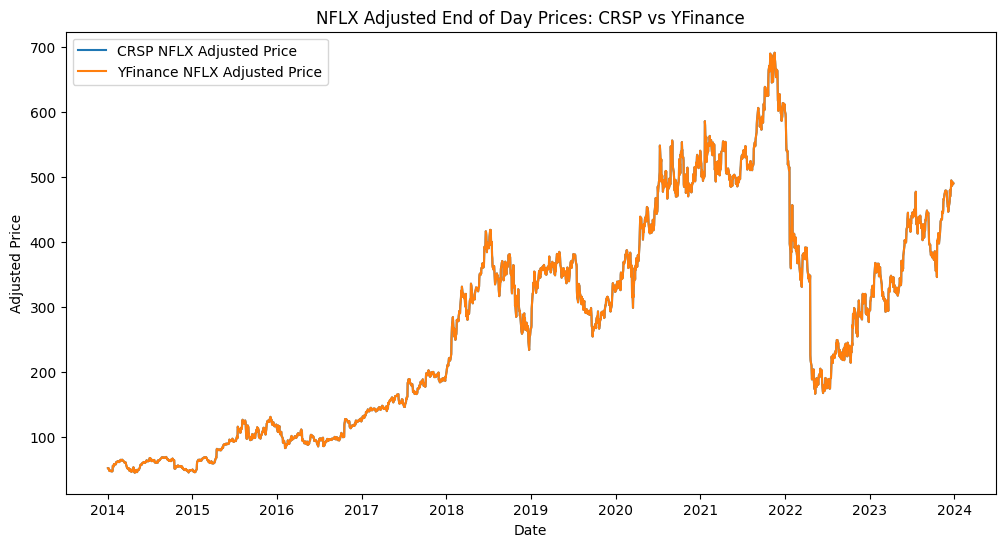

In [100]:
plot_ticker_prices('NFLX', data)

In [95]:
def analyze_ticker_prices(ticker, data):
    """
    Analyze the differences in adjusted prices between CRSP and YFinance data for a given ticker.

    Parameters:
    ticker (str): The stock ticker symbol.
    data (pd.DataFrame): DataFrame containing 'TICKER', 'DATE', 'PRC', and 'CFACPR' columns.
    
    Returns:
    dict: A dictionary containing statistical analysis and other information.
    """
    # Filter the data for only the specified ticker
    ticker_data = data[data['TICKER'] == ticker]

    # Get the date range from the filtered data
    start_date = ticker_data['DATE'].min()
    end_date = pd.to_datetime(ticker_data['DATE'].max()) + pd.Timedelta(days=1)

    # Fetch data from yfinance for the same date range
    ticker_yf = yf.download(ticker, start=start_date, end=end_date)

    # Ensure the date columns are in datetime format
    ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])
    ticker_yf.index = pd.to_datetime(ticker_yf.index)

    # Calculate adjusted prices for CRSP data
    ticker_data['Adj_Price_crsp'] = ticker_data['PRC'] / ticker_data['CFACPR']

    # Extract the adjusted closing prices from YFinance
    ticker_yf['Adj_Price_yf'] = ticker_yf['Adj Close']

    # Merge the two datasets on the date
    merged_data = pd.merge(ticker_data[['DATE', 'Adj_Price_crsp']], 
                           ticker_yf[['Adj_Price_yf']], 
                           left_on='DATE', 
                           right_index=True)

    # Calculate the differences in adjusted prices
    merged_data['Price_Diff'] = merged_data['Adj_Price_crsp'] - merged_data['Adj_Price_yf']

    # Calculate statistics
    avg_diff = merged_data['Price_Diff'].mean()
    max_diff = merged_data['Price_Diff'].max()
    min_diff = merged_data['Price_Diff'].min()

    # Filter the differences greater than 0.0001
    significant_diffs = merged_data[merged_data['Price_Diff'].abs() > 0.0001]

    # Count the number of significant differences
    num_significant_diffs = significant_diffs['Price_Diff'].notna().sum()

    # Calculate the ratio of significant differences to the number of entries
    ratio_significant_diffs = num_significant_diffs / len(merged_data)

    # Calculate statistics for significant differences
    avg_significant_diff = significant_diffs['Price_Diff'].mean()
    max_significant_diff = significant_diffs['Price_Diff'].max()
    min_significant_diff = significant_diffs['Price_Diff'].min()

    # Find dates present in ticker_yf but not in ticker_data
    dates_in_data_not_in_yf = ticker_data[~ticker_data['DATE'].isin(ticker_yf.index)]['DATE']

    # Find dates present in ticker_data but not in ticker_yf
    dates_in_yf_not_in_data = ticker_yf[~ticker_yf.index.isin(ticker_data['DATE'])].index

    # Plot the differences in adjusted prices
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['DATE'], merged_data['Price_Diff'], label=f'{ticker} Adjusted Price Differences', color='black', linestyle='--')
    plt.axhline(0, color='red', linestyle=':', label='Zero Difference')
    plt.legend()
    plt.title(f'{ticker} Adjusted Price Differences: CRSP vs YFinance')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price Difference')
    plt.show()

    return {
        'avg_diff': avg_diff,
        'max_diff': max_diff,
        'min_diff': min_diff,
        'num_significant_diffs': num_significant_diffs,
        'ratio_significant_diffs': ratio_significant_diffs,
        'avg_significant_diff': avg_significant_diff,
        'max_significant_diff': max_significant_diff,
        'min_significant_diff': min_significant_diff,
        'dates_in_crsp_not_in_yf': dates_in_data_not_in_yf,
        'dates_in_yf_not_in_crsp': dates_in_yf_not_in_data
    }


[*********************100%%**********************]  1 of 1 completed
/var/folders/4j/c26320x118b30p_z9wtdxtg40000gn/T/ipykernel_392/1687119959.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['DATE'] = pd.to_datetime(ticker_data['DATE'])
/var/folders/4j/c26320x118b30p_z9wtdxtg40000gn/T/ipykernel_392/1687119959.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['Adj_Price_crsp'] = ticker_data['PRC'] / ticker_data['CFACPR']


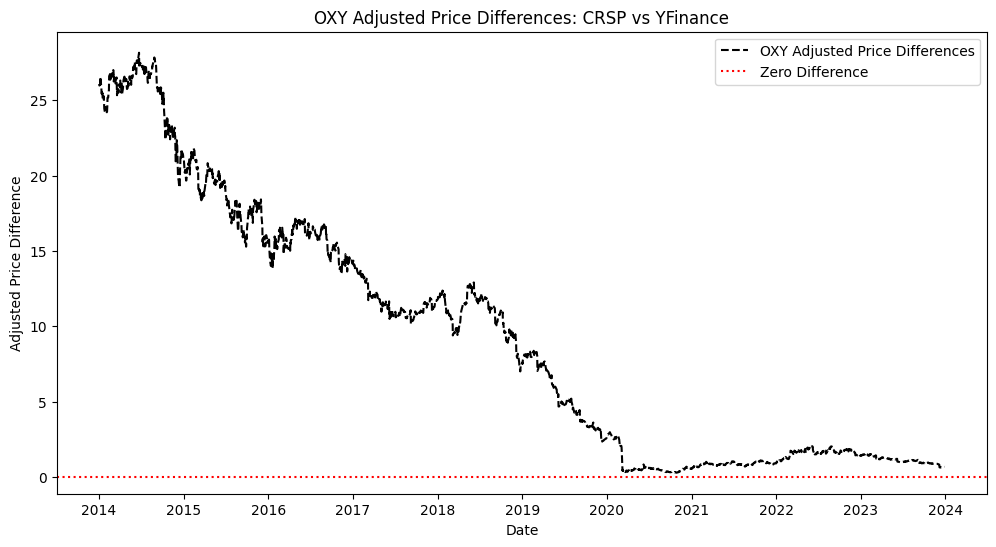

{'avg_diff': np.float64(9.181809639490018),
 'max_diff': np.float64(28.14533775998548),
 'min_diff': np.float64(0.29372013092041094),
 'num_significant_diffs': np.int64(2516),
 'ratio_significant_diffs': np.float64(1.0),
 'avg_significant_diff': np.float64(9.181809639490018),
 'max_significant_diff': np.float64(28.14533775998548),
 'min_significant_diff': np.float64(0.29372013092041094),
 'dates_in_crsp_not_in_yf': Series([], Name: DATE, dtype: datetime64[ns]),
 'dates_in_yf_not_in_crsp': DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)}

In [97]:
analyze_ticker_prices('OXY', data) 